In [0]:
%tensorflow_version 2.x

In [27]:
# TensorFlow and tf.keras
from pylab import subplot,imshow,title,gray,NullLocator
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from keras.models import Model, Sequential
from keras import regularizers
import matplotlib.pyplot as plt
print(tf.__version__)

2.2.0


Using TensorFlow backend.


In [0]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

plt.style.use('fivethirtyeight')

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8

colors = ['#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', '#810f7c', 
'#137e6d', '#be0119', '#3b638c', '#af6f09', '#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', 
'#810f7c', '#137e6d', '#be0119', '#3b638c', '#af6f09']

cmap = mcolors.LinearSegmentedColormap.from_list("", ["#82cafc", "#069af3", "#0485d1", colors[0], colors[8]])

In [3]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
def save_model(m,filename):
    model_json = m.to_json()
    with open("/gdrive/My Drive/colab_data/"+filename+".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    m.save_weights("/gdrive/My Drive/colab_data/"+filename+".h5")
    print("Saved model to disk")

In [0]:
def load_model_weights(filename, model):
    model.load_weights("/gdrive/My Drive/colab_data/"+filename+".h5")
    print("Loaded weights from disk")
    return model

In [0]:
import urllib.request

filepath = "../dataset/"
url = "https://tvml.github.io/ml1920/dataset/"

def get_file(filename,local):
    if local:
        return filepath+filename
    else:
        urllib.request.urlretrieve (url+filename, filename)
        return filename

In [0]:
def get_eigen(A):
    # computing eigenvalues and eigenvectors of the covariance matrix
    # of the set of vectors corresponding to rows of A
    # compute mean for each column (feature)
    means = np.mean(A,axis=0)
    # subtract the mean (along columns): each feature has now zero mean
    M = (A-means)
    # derive the covariance matrix of the set of vectors corresponding to rows of A
    c = np.cov(M, rowvar=0)
    # compute the sets of eigenvalues and eigenvectors of the covariance matrix
    [evals,evects] = np.linalg.eig(c)
    # compute indices of eigenvalues sorted in descending order
    idx = np.argsort(evals) 
    # derive indices of eigenvalues sorted in ascending order
    idx = idx[::-1]       
    # sort eigenvectors (columns of evects) according to the sorted eigenvalues
    evects = evects[:,idx]
    # sort eigenvalues in ascending order
    evals = evals[idx] 
    return evals, evects, M

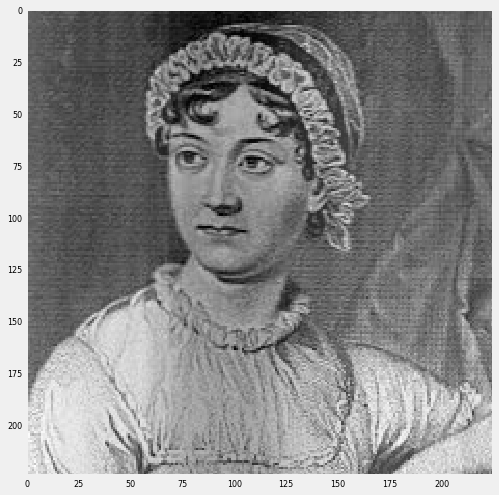

In [20]:
plt.rcParams["axes.grid"] = False
img =plt.imread(get_file('austen.jpg', False))
bw = np.mean(img,2)
val,vec,bw_c=get_eigen(bw)
full_pc = bw.shape[0]
imshow(bw_c, cmap='gray')

In [0]:
dims = img.shape
encoding_dim = 16
input_size = dims[1]*dims[2]

In [0]:
encoding_dim
x_train = img.reshape((dims[0], input_size))

In [113]:
x_train = x_train.astype('float32') / 255.
x_train.shape

(225, 675)

In [166]:
ae = Sequential()

# Encoder Layers
ae.add(Dense(encoding_dim, input_shape=(input_size,), activation='relu'))

# Decoder Layers
ae.add(Dense(input_size, activation='sigmoid'))

ae.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 16)                10816     
_________________________________________________________________
dense_20 (Dense)             (None, 675)               11475     
Total params: 22,291
Trainable params: 22,291
Non-trainable params: 0
_________________________________________________________________


In [0]:
ae.compile(optimizer=keras.optimizers.Adam(
    learning_rate=1), loss='binary_crossentropy')

In [0]:
#ae = load_model_weights('ae_austen', ae)

In [0]:
history = ae.fit(x_train, x_train, epochs=150, batch_size=5)

In [58]:
save_model(ae,'ae_austen')

Saved model to disk


In [177]:
input_img = Input(shape=(input_size,))
encoder_layer1 = ae.layers[0]
encoder = Model(input_img, encoder_layer1(input_img))

encoder.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 675)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 16)                10816     
Total params: 10,816
Trainable params: 10,816
Non-trainable params: 0
_________________________________________________________________


In [0]:
encoded_rows = encoder.predict(x_train)
decoded_rows = ae.predict(x_train)

In [0]:
dec_image = decoded_rows.reshape(-1,225,3)
dec_image = dec_image

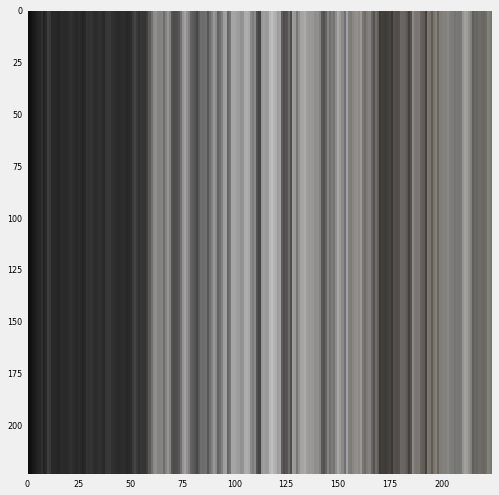

In [180]:
imshow(dec_image, cmap='gray')

In [201]:
ae2 = Sequential()

# Encoder Layers
ae2.add(Dense(9 * encoding_dim, input_shape=(input_size,), activation='relu'))
ae2.add(Dense(3 * encoding_dim, activation='relu'))
ae2.add(Dense(encoding_dim, activation='relu'))

# Decoder Layers
ae2.add(Dense(3 * encoding_dim, activation='relu'))
ae2.add(Dense(9 * encoding_dim, activation='relu'))
ae2.add(Dense(input_size, activation='sigmoid'))

ae2.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 144)               97344     
_________________________________________________________________
dense_28 (Dense)             (None, 48)                6960      
_________________________________________________________________
dense_29 (Dense)             (None, 16)                784       
_________________________________________________________________
dense_30 (Dense)             (None, 48)                816       
_________________________________________________________________
dense_31 (Dense)             (None, 144)               7056      
_________________________________________________________________
dense_32 (Dense)             (None, 675)               97875     
Total params: 210,835
Trainable params: 210,835
Non-trainable params: 0
_______________________________________________

In [0]:
ae2.compile(optimizer='adam', loss='binary_crossentropy')

In [0]:
history2 = ae2.fit(x_train, x_train,
                epochs=150,
                batch_size=5)

In [204]:
input_img = Input(shape=(input_size,))
encoder_layer1 = ae2.layers[0]
encoder_layer2 = ae2.layers[1]
encoder_layer3 = ae2.layers[2]
encoder2 = Model(input_img, encoder_layer3(encoder_layer2(encoder_layer1(input_img))))

encoder2.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 675)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 144)               97344     
_________________________________________________________________
dense_28 (Dense)             (None, 48)                6960      
_________________________________________________________________
dense_29 (Dense)             (None, 16)                784       
Total params: 105,088
Trainable params: 105,088
Non-trainable params: 0
_________________________________________________________________


In [0]:
encoded_rows2 = encoder2.predict(x_train)
decoded_rows2 = ae2.predict(x_train)

In [0]:
dec_image2 = decoded_rows2.reshape(-1,225,3)

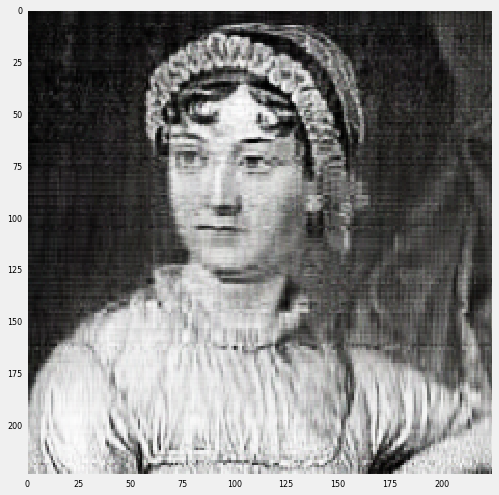

In [207]:
imshow(dec_image2, cmap='gray')

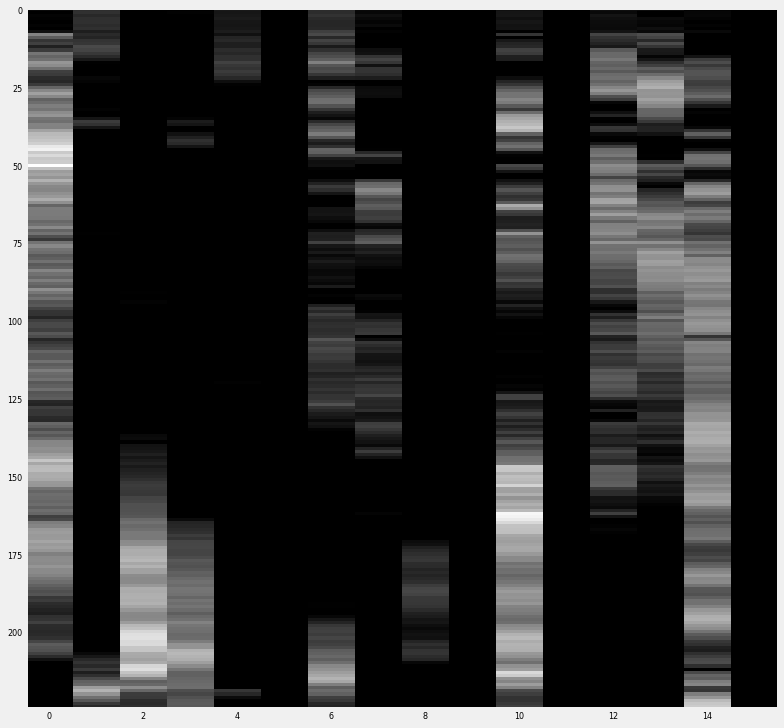

In [208]:
plt.figure(figsize=(12,12))
imshow(encoded_rows2, cmap='gray', aspect='auto')